
Best MAE (train): 0.2529606528830339
Best Parameters: {'model__subsample': 0.9, 'model__n_estimators': np.int64(100), 'model__max_depth': 4, 'model__learning_rate': 0.01, 'model__lambda': 1.5, 'model__gamma': 0, 'model__colsample_bytree': 0.9, 'model__alpha': 0}

Test MAE: 0.28827033482244624
Test RMSE: 0.5391852584542309


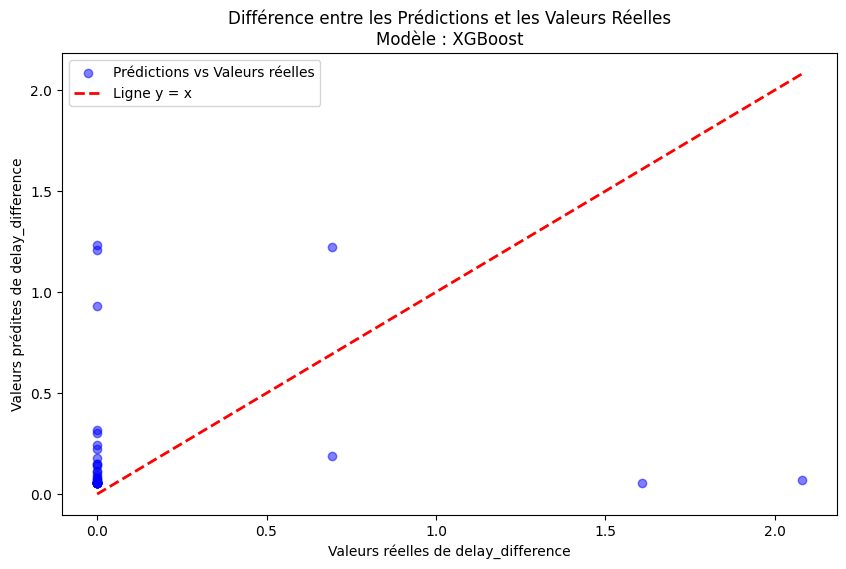

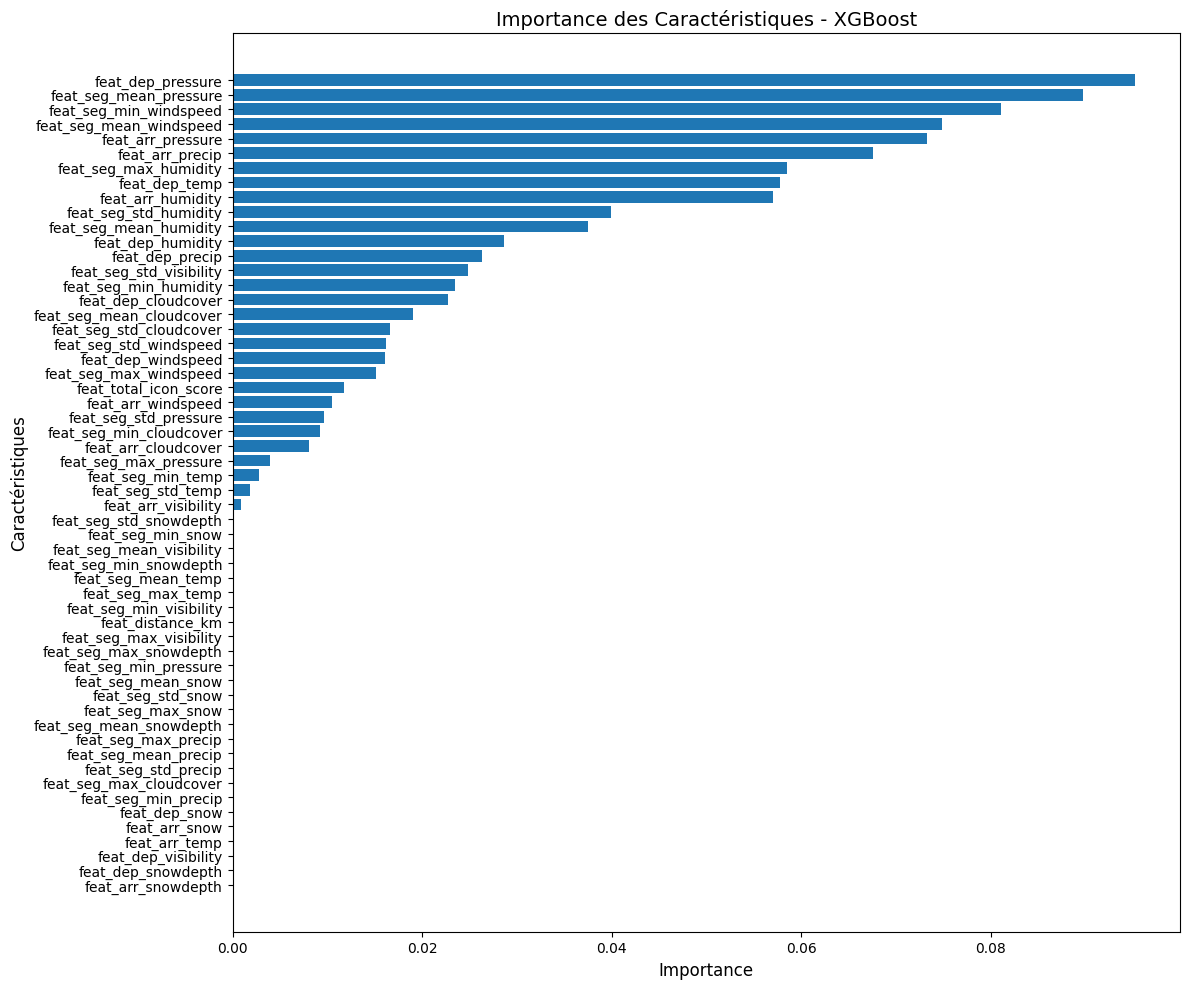

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pymongo import MongoClient
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor


#==========================================================
# Récupérer la collection final_flights dans MongoDB
#==========================================================
# Récupérer l'URI de MongoDB depuis la variable d'environnement
mongo_uri = os.getenv("MONGO_URI")

# Connexion à MongoDB
client = MongoClient(mongo_uri)
db = client.app_data

# Création du DataFrame pandas
df = pd.DataFrame(list(db['final_flights'].find()))

#==========================================================
# Appliquer les transformation avec la classe DataTransform
#==========================================================
from ml_data_transform import DataTransform
datatransform = DataTransform(df)
df = datatransform.remove_na(subset=['target_delay_difference']) # Supprimer les lignes où 'target_delay_difference' est manquant
df = datatransform.add_feat_infos_meteo()                        # Ajout des informations météo
df = datatransform.segment_to_col()                              # Transforme les segments en colonne
df = datatransform.add_feat_icon_score()                         # Ajout du score d'icône
df = datatransform.add_feat_distance_km()                        # Ajout de la distance du vol
df = datatransform.add_target_delay_diff()                       # Ajout de la variable cible 'target_delay_difference'

#==========================================================
# Séparation du Dataset
#==========================================================
# Filtrer les colonnes qui nous intéressent pour l'entraînement
features = [col for col in df.columns if 'feat_' in col]

X = df[features]  # Variables descriptives
y = np.log1p(df['target_delay_difference'])  # Applique une transformation logarithmique

#==========================================================
# Pipelines et comparaison XGBoost
#==========================================================
# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Pipeline de prétraitement
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

X_train = preprocessing_pipeline.fit_transform(X_train)
X_test = preprocessing_pipeline.transform(X_test)

# Définition des hyperparamètres pour XGBoost
xgb_params = {
    'model__n_estimators': np.arange(100, 301, 50),  # Affiné autour des valeurs testées
    'model__learning_rate': [0.005, 0.01, 0.05],  # Valeurs faibles pour un apprentissage plus progressif
    'model__max_depth': [4, 6, 8],  # Restriction de la profondeur pour éviter la complexité excessive
    'model__subsample': [0.7, 0.8, 0.9],
    'model__colsample_bytree': [0.7, 0.8, 0.9],
    'model__gamma': [0, 0.1, 0.2],  # Plus de valeurs fines autour des valeurs faibles
    'model__alpha': [0, 0.1, 0.5],  # Régularisation L1
    'model__lambda': [1, 1.5, 2]  # Régularisation L2
}

# Pipeline avec XGBoost
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Optimisation des hyperparamètres avec RandomizedSearchCV
random_search_xgb = RandomizedSearchCV(
    xgb_pipeline,
    xgb_params,
    cv=5,  # Garde une validation croisée modérée
    scoring='neg_mean_absolute_error',
    n_iter=50,  # Limite à 50 itérations pour réduire les temps de calcul
    n_jobs=-1,
    random_state=42
)

# Entraînement du modèle avec early stopping
random_search_xgb.fit(X_train, y_train)

# Meilleurs hyperparamètres et score
best_model_xgb = random_search_xgb.best_estimator_
best_score_xgb = -random_search_xgb.best_score_
best_params_xgb = random_search_xgb.best_params_

print(f"\nBest MAE (train): {best_score_xgb}")
print(f"Best Parameters: {best_params_xgb}")

# Évaluation sur l'ensemble de test
y_pred = np.expm1(best_model_xgb.predict(X_test))  # Enlève la transformation logarithmique

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nTest MAE: {mae}")
print(f"Test RMSE: {rmse}")

# Graphique de la différence entre les prédictions et les valeurs réelles
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label="Prédictions vs Valeurs réelles")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label="Ligne y = x")
plt.xlabel("Valeurs réelles de delay_difference")
plt.ylabel("Valeurs prédites de delay_difference")
plt.title("Différence entre les Prédictions et les Valeurs Réelles\nModèle : XGBoost")
plt.legend()
plt.savefig('output.png')

# Graphique des importances des caractéristiques
feature_importances = best_model_xgb['model'].feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(12, 10))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx], fontsize=10)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Caractéristiques", fontsize=12)
plt.title("Importance des Caractéristiques - XGBoost", fontsize=14)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.show()
